### **Project Proposal Paul Staskiewicz**

# **What is the Problem?**

**Informal Description:**
- I need a program that can tell me, the demand for bikesharing in Cologne for the next day. And it should tell me the reasons for the resulting demand.

**Formal Description:** 
- Task: Tell me the bikesharing demand for the next 24 hours.
- Experience: Two months of bike trips in Cologne.
- Presicion: Prediction Accuracy, the demand for the next 24 hours, compared to the predicted demand.

**Assumptions:**
- The weather has an important role.
- The time of the day is important (Rush Hour?).
- The bike type is not so important.
- The location of the trip start and end is important.

**Similiar Problems:** 
- Rush Hours (high demand) on highways.

# **Why does the problem need to be solved?**

**Motivation:**
- Manual vehicle redistribution is still a problem for bike sharing services. 
(J. Pfrommer, J. Warrington, G. Schildbach and M. Morari, "Dynamic Vehicle Redistribution and Online Price Incentives in Shared Mobility Systems," in IEEE Transactions on Intelligent Transportation Systems, vol. 15, no. 4, pp. 1567-1578, Aug. 2014, doi: 10.1109/TITS.2014.2303986.)

**Solution Benefits:**
- The program enables to automate the prediction of demand for coming days. 
- According to this prediction it becomes easier to redistribute bikes and assure avaibility of bikes in high demand areas. 

**Solution Use:**
- The soultion could include a daily and weekly report over the expected demand patterns.

# **How would I solve the problem?**

- I would start looking at the weather for the next day, wether its a weekday or weekend, this could help me predict an overall demand. 
If it is a sunny day and a friday evening the demand should be high.

- For the programm its important to know the weather for the next 24 hours and which weekday it is. This data is avaible from the Deutschen Wetterdienst.

-  To match each trip to district/location in Cologne one can retrieve this data from open data cologne (https://www.offenedaten-koeln.de/).




# **Used algorithim:**

- Co-occurrence Grouping in combination with the apriori algorithm from mlxtend
- Each trip represents a transaction with some additional attributes, like weather (sunny, cloudy), starting district (Köln HBF) and time of day (evening, afternoon). 

- With the use of the tools mlxtend provides it is possible to "mine" association rules. These rules describe which attributes have an association and how strong it is compared to others.

# Additional packages:

In [1]:
%pip install geopandas
%pip install pandarallel
%pip install mlxtend
%pip install descartes

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Imports:

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# needed for operations on geospatial data
import geopandas as gpd
from shapely.geometry import Point
from shapely.ops import nearest_points

# ml imports
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
from sklearn.cluster import KMeans

# needed for parallelizing
import multiprocessing
from pandarallel import pandarallel
from pandarallel.utils import progress_bars

In [3]:
pandarallel.initialize(progress_bar=True)

progress_bars.is_notebook_lab = lambda : True

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


# Retrieving the data (hosted on onedrive to avoid uploading the data every time):

- The wetaher data was retrieved from the Deutschen Wetterdienst (DWD)
- https://cdc.dwd.de/portal/202007291339/searchview
- The weather data is provided as csv and was uploaded to onedrive


In [4]:
# provided trip data
df_trips = pd.read_csv("https://onedrive.live.com/download?cid=2BAFD0B2518A0812&resid=2BAFD0B2518A0812%21171155&authkey=AHdtGgklnlkhPZw")

# weather data
df_temp = pd.read_csv("https://onedrive.live.com/download?cid=2BAFD0B2518A0812&resid=2BAFD0B2518A0812%21171156&authkey=ALJ1fQxjqReiTOY")
df_clouds = pd.read_csv("https://onedrive.live.com/download?cid=2BAFD0B2518A0812&resid=2BAFD0B2518A0812%21171163&authkey=AOE8hIvWJPAZb9U")

# geojson which contains the districts of cologne
df_cng = gpd.read_file("https://geoportal.stadt-koeln.de/arcgis/rest/services/Stadtgliederung_15/MapServer/2/query?where=objectid%20is%20not%20null&text=&objectIds=&time=&geometry=&geometryType=esriGeometryEnvelope&inSR=&spatialRel=esriSpatialRelIntersects&relationParam=&outFields=%2A&returnGeometry=true&returnTrueCurves=false&maxAllowableOffset=&geometryPrecision=&outSR=4326&returnIdsOnly=false&returnCountOnly=false&orderByFields=&groupByFieldsForStatistics=&outStatistics=&returnZ=false&returnM=false&gdbVersion=&returnDistinctValues=false&resultOffset=&resultRecordCount=&f=pjson")
df_poi = pd.read_json("https://onedrive.live.com/download?cid=2BAFD0B2518A0812&resid=2BAFD0B2518A0812%21175256&authkey=AAMB6QG5suIMWQE")

# Data Preprocessing:

In [5]:
# convert all time columns to datetime
df_temp.Zeitstempel = pd.to_datetime(df_temp.Zeitstempel, format="%Y%m%d%H%M")
df_clouds.Zeitstempel = pd.to_datetime(df_clouds.Zeitstempel, format="%Y%m%d%H%M")
df_trips.start_datetime = pd.to_datetime(df_trips.start_datetime)

In [6]:
# filter outliers based on lat/lng
filter = (df_trips['start_lng'] > 6.7) & (df_trips['start_lng'] < 7.1) & (df_trips['start_lat'] > 50.85) & (df_trips['start_lat'] < 51.05) & (df_trips["service"] == "koeln")

df_filtered = df_trips[filter]

In [7]:
# settings
SAMPLE_PERIOD = '1H' # sample period, other values possible (see https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects)
START = '2020-09-01 00:00:00' # start datetime
END = '2020-10-31 23:00:00' # end datetime'])

# we have multiple records for single minutes, so we have to aggregate them first
df_starts = df_trips.groupby(['start_datetime']).agg({'start_datetime': 'size'})

# rename column
df_starts.columns = ['no_trip_starts']

# resample to the specified sample period
df_starts = df_starts.resample(SAMPLE_PERIOD).agg({'no_trip_starts': 'sum'})

# create date range
idx = pd.date_range(START, END, freq=SAMPLE_PERIOD)

# reindex df (set 0 if no record found for time slot)
df_starts = df_starts.reindex(idx, fill_value=0)

In [8]:
gdf_poi = gpd.GeoDataFrame(
    df_poi, geometry=gpd.points_from_xy(df_poi.lng, df_poi.lat))

# Visualization of temperature, humidity and trip starts over time:

In [9]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)

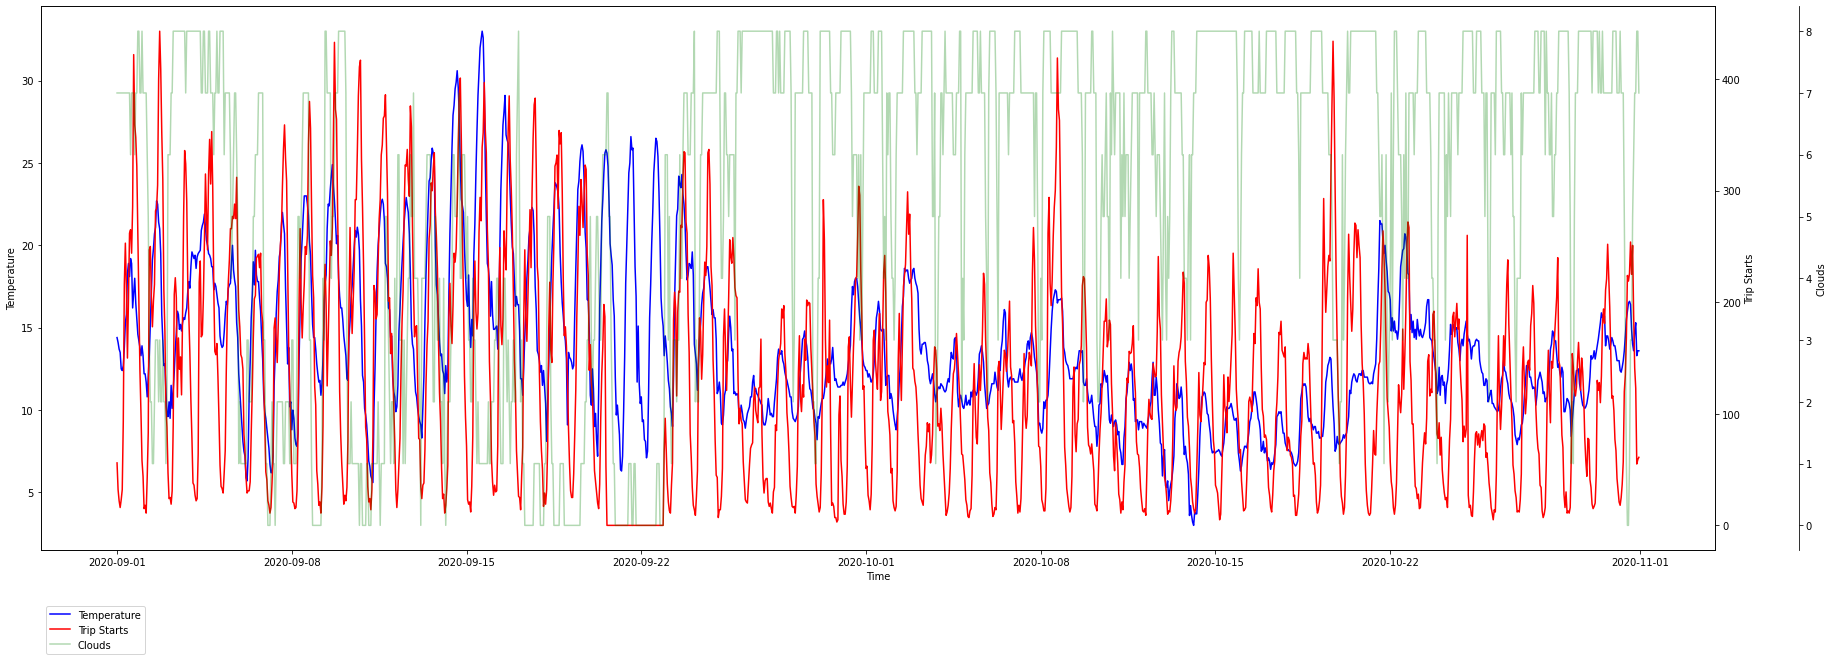

In [10]:
fig, host = plt.subplots(figsize=(30,10))

par1 = host.twinx()
par2 = host.twinx()

# Offset the right spine of par2. The ticks and label have already been
# placed on the right by twinx above.
par2.spines["right"].set_position(("axes", 1.05))

# Having been created by twinx, par2 has its frame off, so the line of its
# detached spine is invisible.  First, activate the frame but make the patch
# and spines invisible.
make_patch_spines_invisible(par2)

# Second, show the right spine.
par2.spines["right"].set_visible(True)

# Plot all three lines
p1, = host.plot(df_temp.Zeitstempel, df_temp.Wert, "b-", label="Temperature")
p2, = par1.plot(df_starts.index, df_starts.no_trip_starts, "r-", label="Trip Starts")
p3, = par2.plot(df_clouds.Zeitstempel, df_clouds.Wert, "g-", label="Clouds", alpha=0.3)

# Set all labels
host.set_xlabel("Time")
host.set_ylabel("Temperature")
par2.set_ylabel("Clouds")
par1.set_ylabel("Trip Starts")

# Add a legend
lines = [p1, p2, p3]
host.legend(lines, [l.get_label() for l in lines], loc="lower left", bbox_to_anchor=(0, -0.2))

# Data Preperation:
1. Add the additional attributes to all trips
2. These could include: Weather (clouds, temperature), starting and ending district, etc. 

In [11]:
# The current index of df_starts is the timestamp
# To make the following merges easier, the timestamp was moved from the index into a own column.

df_starts = df_starts.reset_index()
df_starts = df_starts.rename(columns={"index": "time"})

In [12]:
# First merge: Merge of the temperature on the trips dataframe (df_starts).

temp_merge = pd.merge(df_starts, df_temp[["Wert", "Zeitstempel"]], left_on="time", right_on="Zeitstempel").drop("Zeitstempel", 1)
temp_merge_final = temp_merge.rename(columns={"Wert": "temp"})
 
# Second merge: Merge of the clouds on the result of the first merge 
cloud_merge = pd.merge(temp_merge_final, df_clouds[["Wert", "Zeitstempel"]], left_on="time", right_on="Zeitstempel").drop("Zeitstempel", 1)
cloud_merge_final = cloud_merge.rename(columns={"Wert": "clouds"})

merged_data = cloud_merge_final

# The final result
merged_data.head()

,time,no_trip_starts,temp,clouds
0,2020-09-01 00:00:00,56,14.4,7
1,2020-09-01 01:00:00,32,14.1,7
2,2020-09-01 02:00:00,22,13.7,7
3,2020-09-01 03:00:00,16,13.5,7
4,2020-09-01 04:00:00,23,12.5,7


# Functions to convert attributes into categorical values

In [13]:
def matchTempLabels(row):
  if row["temp"] > 38:
    return "very hot"
  if (row["temp"] > 32) & (row["temp"] <= 38):
    return "hot"
  if (row["temp"] > 26) & (row["temp"] <= 32):
    return "warm"
  if (row["temp"] > 20) & (row["temp"] <= 26):
    return "slightly warm"
  if (row["temp"] > 0) & (row["temp"] <= 20):
    return "neutral"

In [14]:
def matchDemand(row):
  if row["no_trip_starts"] > 194:
    return "high demand"
  if (row["no_trip_starts"] > 116) & (row["temp"] <= 194):
    return "average demand"
  if (row["no_trip_starts"] > 41) & (row["temp"] <= 116):
    return "low demand"
  else:
    return "no demand"

In [15]:
def matchCloudLabels(row):
  if row["clouds"] == 8:
    return "covered"
  if row["clouds"] == 7:
    return "almost covered"
  if row["clouds"] == 6:
    return "very cloudy"
  if row["clouds"] == 5:
    return "cloudy"
  if row["clouds"] == 4:
    return "some clouds"
  if row["clouds"] == 3:
    return"slighty cloudy"
  if row["clouds"] == 2:
    return "bright"
  if row["clouds"] == 1:
    return "sunny"
  if row["clouds"] == 0:
    return "no clouds"

In [16]:
def matchWeekday(row):
  day = row["time"].strftime('%A')
  return day

In [17]:
def matchTimeOfDay(row):
  if (int(row["time"].strftime("%H")) >= 0) & (int(row["time"].strftime("%H")) <= 6):
    return "night"
  if (int(row["time"].strftime("%H")) > 6) & (int(row["time"].strftime("%H")) <= 12):
    return "morning"
  if (int(row["time"].strftime("%H")) > 12) & (int(row["time"].strftime("%H")) <= 18):
    return "afternoon"
  if (int(row["time"].strftime("%H")) > 18):
    return "evening"

# Adding of the categorical values

In [18]:
merged_data["thermal_sensation"] = merged_data.apply(lambda row: matchTempLabels(row), axis=1)
merged_data["demand"] = merged_data.apply(lambda row: matchDemand(row), axis=1)
merged_data["cloud_cover"] = merged_data.apply(lambda row: matchCloudLabels(row), axis=1)
merged_data["time_of_day"] = merged_data.apply(lambda row: matchTimeOfDay(row), axis=1)
merged_data["day"] = df_starts.apply(lambda row: matchWeekday(row), axis=1)

# Drop not needed columns
merged_data_final = merged_data.drop(columns=["time", "no_trip_starts", "temp", "clouds"])

merged_data.head()

,time,no_trip_starts,temp,clouds,thermal_sensation,demand,cloud_cover,time_of_day,day
0,2020-09-01 00:00:00,56,14.4,7,neutral,low demand,almost covered,night,Tuesday
1,2020-09-01 01:00:00,32,14.1,7,neutral,no demand,almost covered,night,Tuesday
2,2020-09-01 02:00:00,22,13.7,7,neutral,no demand,almost covered,night,Tuesday
3,2020-09-01 03:00:00,16,13.5,7,neutral,no demand,almost covered,night,Tuesday
4,2020-09-01 04:00:00,23,12.5,7,neutral,no demand,almost covered,night,Tuesday


# Rule Mining (for trips in one hour time steps):

In [19]:
# Create a numpy array so that the Transaction Encoder can work with it
np_data = merged_data_final.to_numpy()

# Creation of the Transaction Encoder
te = TransactionEncoder()

# Transformation of data
data_transformed = te.fit(np_data).transform(np_data)
df_matrix = pd.DataFrame(data_transformed, columns=te.columns_)

df_matrix.head(10)

,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,afternoon,almost covered,average demand,...,neutral,night,no clouds,no demand,slightly warm,slighty cloudy,some clouds,sunny,very cloudy,warm
0,False,False,False,False,False,True,False,False,True,False,...,True,True,False,False,False,False,False,False,False,False
1,False,False,False,False,False,True,False,False,True,False,...,True,True,False,True,False,False,False,False,False,False
2,False,False,False,False,False,True,False,False,True,False,...,True,True,False,True,False,False,False,False,False,False
3,False,False,False,False,False,True,False,False,True,False,...,True,True,False,True,False,False,False,False,False,False
4,False,False,False,False,False,True,False,False,True,False,...,True,True,False,True,False,False,False,False,False,False
5,False,False,False,False,False,True,False,False,True,False,...,True,True,False,True,False,False,False,False,False,False
6,False,False,False,False,False,True,False,False,True,False,...,True,True,False,False,False,False,False,False,False,False
7,False,False,False,False,False,True,False,False,True,False,...,True,False,False,False,False,False,False,False,False,False
8,False,False,False,False,False,True,False,False,True,False,...,True,False,False,False,False,False,False,False,False,False
9,False,False,False,False,False,True,False,False,True,False,...,True,False,False,False,False,False,False,False,False,False


In [20]:
# Running the apriori algorithim
apr = apriori(df_matrix, min_support= 0.02, use_colnames=True )

# Generation of association rules
rules = association_rules(apr, metric='confidence', min_threshold=0.25) 

In [21]:
rules.sort_values(['lift'], ascending=False).head(50)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
432,"(Monday, night)","(neutral, no demand)",0.038278,0.237184,0.032126,0.839286,3.538545,0.023047,4.746411
294,"(high demand, afternoon)",(slightly warm),0.143541,0.091593,0.046480,0.323810,3.535323,0.033333,1.343419
295,(slightly warm),"(high demand, afternoon)",0.091593,0.143541,0.046480,0.507463,3.535323,0.033333,1.738872
450,"(Thursday, neutral, no demand)",(night),0.030075,0.291866,0.030075,1.000000,3.426230,0.021297,inf
232,"(Thursday, no demand)",(night),0.030075,0.291866,0.030075,1.000000,3.426230,0.021297,inf
422,"(Friday, neutral, no demand)",(night),0.030075,0.291866,0.030075,1.000000,3.426230,0.021297,inf
146,"(Friday, no demand)",(night),0.030075,0.291866,0.030075,1.000000,3.426230,0.021297,inf
425,"(Friday, no demand)","(neutral, night)",0.030075,0.291866,0.030075,1.000000,3.426230,0.021297,inf
453,"(Thursday, no demand)","(neutral, night)",0.030075,0.291866,0.030075,1.000000,3.426230,0.021297,inf
555,"(no clouds, night)","(neutral, no demand)",0.025290,0.237184,0.020506,0.810811,3.418491,0.014507,4.032028


# Data Preperation (for **single** trips):

For single trips it is now possible to add and end and start districts.

Districts of Cologne:

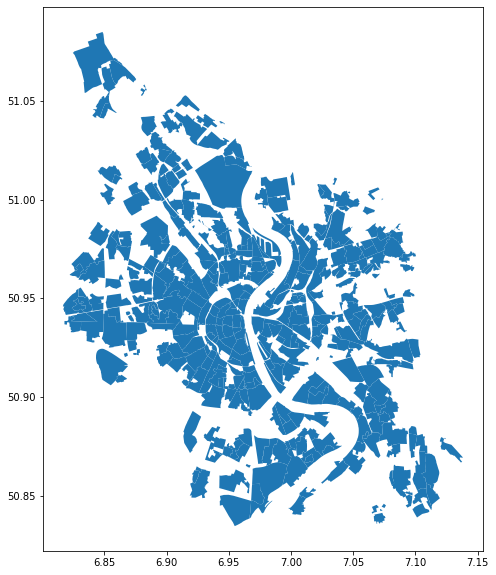

In [22]:
df_cng.plot(figsize=(10,10))

In [23]:
df_cng.head()

,OBJECTID,NUMMER,NAME,NR_STADTBEZIRK,STADTBEZIRK,NR_STADTTEIL,STADTTEIL,FLAECHE,NAME_LANG,geometry
0,1,61201,Alt-Worringen,6,Chorweiler,612,Worringen,1011021.0,Alt-Worringen,"POLYGON ((6.85772 51.07053, 6.85791 51.07044, ..."
1,2,61203,Am Worringer Bruch,6,Chorweiler,612,Worringen,71032.0,Am Worringer Bruch,"POLYGON ((6.88376 51.05602, 6.88394 51.05558, ..."
2,3,61103,Thenhoven,6,Chorweiler,611,Roggendorf/Thenhoven,306731.0,Thenhoven,"POLYGON ((6.84631 51.04144, 6.84636 51.04159, ..."
3,4,60101,Rheinkassel,6,Chorweiler,601,Merkenich,443793.0,Rheinkassel,"POLYGON ((6.93200 51.04295, 6.93208 51.04290, ..."
4,5,61001,Siedlung Blumenberg,6,Chorweiler,610,Blumenberg,697926.0,Siedlung Blumenberg,"POLYGON ((6.89022 51.04245, 6.89016 51.04205, ..."


In [24]:
# The checking of the start and ending districts contains many operations, so multiprocessing is needed.

num_processes = multiprocessing.cpu_count()
chunks = np.array_split(df_filtered, num_processes)
combined_chunks = [(chunk, df_cng) for chunk in chunks]

In [25]:
# Function for mapping the start and end district to each trip.

def map_districts(trip_data_chunks, geojson):

    # First we iterate over each trip in the trip_data
    for row in trip_data_chunks.itertuples():

        # And select for the trip the starting and ending point
        starting_point = Point(row[5], row[4])
        ending_point = Point(row[7], row[6])

        # Then we iterate for this one trip over the districts in the GeoJson
        for geo_row in geojson.itertuples():

            # And check whether it contains the starting point
            if geo_row[10].contains(starting_point):

                # And add it to the the row
                trip_data_chunks.at[row.Index, "start_stadtviertel"] = "SV_" + geo_row[3]
                trip_data_chunks.at[row.Index, "start_stadtbezirk"] = "SB_" + geo_row[5]
                trip_data_chunks.at[row.Index, "start_stadtteil"] = "ST_" + geo_row[7]
               
            # Same for the ending point
            if geo_row[10].contains(ending_point):
                trip_data_chunks.at[row.Index, "end_stadtviertel"] = "EV_" + geo_row[3]
                trip_data_chunks.at[row.Index, "end_stadtbezirk"] = "EB_" + geo_row[5]
                trip_data_chunks.at[row.Index, "end_stadtteil"] = "ET_" + geo_row[7]

    return trip_data_chunks

In [26]:
# The actual mapping of the districts to the trips.
# CAUTION: May take a while (10-20min)

pool = multiprocessing.Pool(processes=num_processes)

result = pool.starmap(map_districts, combined_chunks)

trip_data = pd.concat(result)

pool.close()

In [27]:
gdf_poi.head()

,id,title,category,lat,lng,geometry
0,2768lxx5-013e5332df0d0e3a9fbbbe34122b7eb2,M.G. Autoankauf Köln Umland,Service,50.999160,6.910750,POINT (6.91075 50.99916)
1,276u1hfj-ff4fdf7caa674554b23e16b4e66ec2af,Hotel Bauernschaenke,Hotel,50.999218,6.911335,POINT (6.91134 50.99922)
2,276u1hfj-e4232bd7d5554137b876f6c1d6914498,Longerich Stommeler Str.,Public Transport,50.999254,6.912068,POINT (6.91207 50.99925)
3,276q9wpy-59fb98ada12d0c363eb4c72311c3bc6c,"Köln, Longerich Stommeler STR.",Public Transport,50.998980,6.912060,POINT (6.91206 50.99898)
4,276u1hfj-73e600b21b52474f974bb83f04e324ee,Nelles Bäckerei,Food & Drink,50.998980,6.912060,POINT (6.91206 50.99898)


In [28]:
trip_data.head()

,b_number,start_datetime,end_datetime,start_lat,start_lng,end_lat,end_lng,b_type,station_name,service,end_stadtviertel,end_stadtbezirk,end_stadtteil,start_stadtviertel,start_stadtbezirk,start_stadtteil
0,21270,2020-09-01 00:01:00,2020-09-01 00:25:00,50.935641,6.931475,50.954054,6.931364,15,BIKE 21270,koeln,EV_Neuehrenfeld,EB_Ehrenfeld,ET_Neuehrenfeld,SV_Komponisten-Viertel,SB_Innenstadt,ST_Neustadt/Süd
1,22023,2020-09-01 00:04:00,2020-09-01 00:47:00,50.923297,6.927435,50.926935,6.944707,15,BIKE 22023,koeln,EV_Volksgarten-Viertel,EB_Innenstadt,ET_Neustadt/Süd,SV_Sülz,SB_Lindenthal,ST_Sülz
2,21721,2020-09-01 00:06:00,2020-09-01 00:12:00,50.917707,6.924668,50.916696,6.927324,15,BIKE 21721,koeln,EV_Sülz,EB_Lindenthal,ET_Sülz,SV_Sülz,SB_Lindenthal,ST_Sülz
3,22146,2020-09-01 00:10:00,2020-09-01 10:39:00,50.934962,6.962002,50.934962,6.962002,15,BIKE 22146,koeln,EV_Martins-Viertel,EB_Innenstadt,ET_Altstadt/Nord,SV_Martins-Viertel,SB_Innenstadt,ST_Altstadt/Nord
4,21842,2020-09-01 00:11:00,2020-09-01 00:35:00,50.996325,6.927981,50.975887,6.936069,15,BIKE 21842,koeln,EV_Nibelungen-Siedlung,EB_Nippes,ET_Mauenheim,SV_Gartenstadt-Nord,SB_Nippes,ST_Longerich


In [ ]:
# unary union of the gdf_poi geomtries 
poi_pts = gdf_poi.geometry.unary_union

def near(point, pts=poi_pts):
     # find the nearest point and return the corresponding Place
     nearest = gdf_poi.geometry == nearest_points(point, pts)[1]

     return gdf_poi[nearest].title
  
trip_data['nearest_poi'] = trip_data.parallel_apply(lambda row: near(Point(row.end_lng, row.end_lat)), axis=1)

In [ ]:
trip_data.head()

The next step is to add for each trip the termperature, cloud cover, day, etc.

I also add the overall demand for cologne for each trip as additional attribute.

In [ ]:
# As we only know the weather data for full hours, we have to assume this temperature for trips which are near this full hour data points.
# Eg.: Temperature at 3pm is valid for the trips from 2:30pm to 3:30pm

# We use pd.merge_asof to merge the temperature to the trips.
# The tolerance has to be 30 minutes, as this is the biggest deviation a trip can have from nearest temperature data point. 
tol = pd.Timedelta('30M')

# Merge of the temperature
merge_temp = pd.merge_asof(left=trip_data.sort_values("start_datetime"), right=df_temp[["Zeitstempel", "Wert"]]
                          .sort_values("Zeitstempel"), left_on="start_datetime", right_on="Zeitstempel", direction='nearest', tolerance=tol).drop(columns="Zeitstempel")

# Merge of the clouds
merge_clouds = pd.merge_asof(left=merge_temp.sort_values("start_datetime"), right=df_clouds[["Zeitstempel", "Wert"]]
                             .sort_values("Zeitstempel"), left_on="start_datetime", right_on="Zeitstempel", direction='nearest', tolerance=tol).drop(columns="Zeitstempel")

# Merge of the demand
merge_demand = pd.merge_asof(left=merge_clouds.sort_values("start_datetime"), right=merged_data[["time", "demand"]]
                             .sort_values("time"), left_on="start_datetime", right_on="time", direction='nearest', tolerance=tol).drop(columns="time")


merged_trips = merge_demand.rename(columns={"Wert_x": "temp", "Wert_y": "clouds", "start_datetime": "time" })

# Conversion into categorical values 
merged_trips["cloud_cover"] = merged_trips.apply(lambda row: matchCloudLabels(row), axis=1)
merged_trips["time_of_day"] = merged_trips.apply(lambda row: matchTimeOfDay(row), axis=1)
merged_trips["day"] = merged_trips.apply(lambda row: matchWeekday(row), axis=1)
merged_trips["thermal_sensation"] = merged_trips.apply(lambda row: matchTempLabels(row), axis=1)

# We drop columns we do not need
cleaned_trips = merged_trips.drop(columns=["b_number","end_datetime", "start_lat", "start_lng", "start_lng", "end_lng", "end_lat", "b_type", "station_name", "service", "temp", "clouds", "time"])

# As some of the trips do not lie in the city districts of cologne we replace this NA Values with "Unbekannt"
cleaned_trips[["end_stadtviertel", "end_stadtbezirk", "end_stadtteil", "start_stadtviertel", "start_stadtbezirk", "start_stadtteil"]] = (
    cleaned_trips[["end_stadtviertel", "end_stadtbezirk", "end_stadtteil", "start_stadtviertel", "start_stadtbezirk", "start_stadtteil"]].fillna("Unbekannt"))

In [ ]:
cleaned_trips.head()

In [ ]:
# We need to drop the last values of the df because cant match any weather to them, because we dont have weather data for them
np_trips_data = cleaned_trips.dropna().to_numpy()

te = TransactionEncoder()
trips_data_transformed = te.fit(np_trips_data).transform(np_trips_data)
trips_matrix = pd.DataFrame(trips_data_transformed, columns=te.columns_)

trips_matrix.head(10)

In [ ]:
apr2 = apriori(trips_matrix, min_support= 0.02, use_colnames=True )

rules2 = association_rules(apr2, metric='lift', min_threshold=0.25) 

In [ ]:
df_sorted = rules.sort_values(['lift'], ascending=False)

df_sorted["consequents_"] = df_sorted["consequents"].apply(lambda x: list(x)[0]).astype("unicode")

filter_demand = df_sorted["consequents_"].str.contains("demand")

df_sorted[filter_demand].head(50)

# Rule Minig with clustered trips

In [ ]:
merged_trips.head()

# Choosing the to be clustered attributes

In [ ]:
clustering_data = merged_trips.dropna()[["start_lat", "start_lng", "end_lat", "end_lng", "temp", "clouds"]]

clustering_data.shape

In [ ]:
MIN_K = 1
MAX_K = 11

# we store the inertia for each k here
inertia = []

# for each k
for k in range(MIN_K , MAX_K):
    # run kmeans
    test_model = KMeans(k, random_state=0).fit(clustering_data.values)
    inertia.append(test_model.inertia_)

# create elbow plot
plt.figure(1 , figsize = (15 ,6))
plt.plot(np.arange(1 , 11) , inertia , 'o')
plt.plot(np.arange(1 , 11) , inertia , '-' , alpha = 0.5)
plt.xlabel('Number of Clusters') , plt.ylabel('Inertia')
plt.show()

In [ ]:
model = KMeans(3, random_state=0).fit(clustering_data.values)

In [ ]:
# for each cluster centroid
for idx, centroid in enumerate(model.cluster_centers_):
  print('*'*30)
  print('Cluster: ' + str(idx+1))
  print('start_lat: ' + str(centroid[0]))
  print('start_lng: ' + str(centroid[1]))
  print('end_lat: ' + str(centroid[2]))
  print('end_lng: ' + str(centroid[3]))
  print('temp: ' + str(centroid[4]))
  print('clouds: ' + str(centroid[5]))

In [ ]:
clustering_data["cluster_idx"] = model.labels_

clustering_data.plot(x="start_lng", y="start_lat", kind="scatter", figsize=[15, 15], c="cluster_idx", cmap="plasma", s=5)

In [ ]:
plot = df_cng.plot(figsize=(10,30))

#all points
plot.scatter(clustering_data.start_lng, clustering_data.start_lat, c="black", s=1)

#starting points
plot.scatter(model.cluster_centers_[0][1], model.cluster_centers_[0][0], c="g")
plot.scatter(model.cluster_centers_[1][1], model.cluster_centers_[1][0], c="y")
plot.scatter(model.cluster_centers_[2][1], model.cluster_centers_[2][0], c="r")

In [ ]:
plot = df_cng.plot(figsize=(10,30))

#all points
plot.scatter(clustering_data.start_lng, clustering_data.start_lat, c="black", s=1)

#ending points
plot.scatter(model.cluster_centers_[0][3], model.cluster_centers_[0][2], c="g")
plot.scatter(model.cluster_centers_[1][3], model.cluster_centers_[1][2], c="y")
plot.scatter(model.cluster_centers_[2][3], model.cluster_centers_[2][2], c="r")

In [ ]:
drop_na = merged_trips.dropna()

drop_na.head()